In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import warnings
from collections import UserDict
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
%matplotlib inline
import matplotlib.dates as mpl_dates
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import math
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

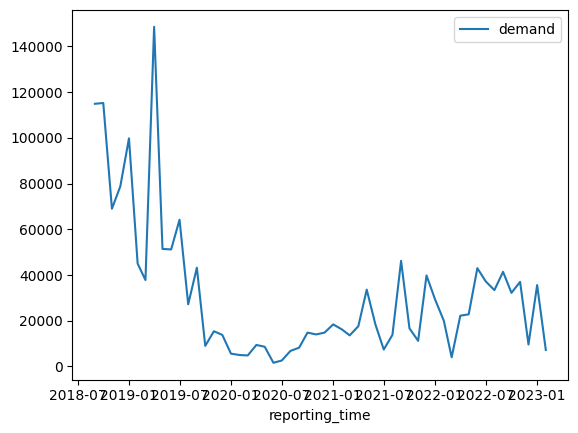

In [51]:
data = pd.read_csv('20230411_SummerTerm23_Data_Challenge_Infineon_Data.csv')
data_new = data
data_new['reporting_time'] = pd.to_datetime(data_new['reporting_time'])
data_new['reporting_time'] = data_new['reporting_time'].dt.date
data_gb = data.groupby('product_name')['reporting_time'].nunique()
data_p1801 = data_new.loc[data['product_name']=='P1801']
data_p1801 = data_p1801[['reporting_time', 'demand']]
data_p1801.reset_index(inplace=True, drop=True)
data_p1801.plot(x = 'reporting_time', y = 'demand')
data_p1801 = data_p1801.set_index('reporting_time')


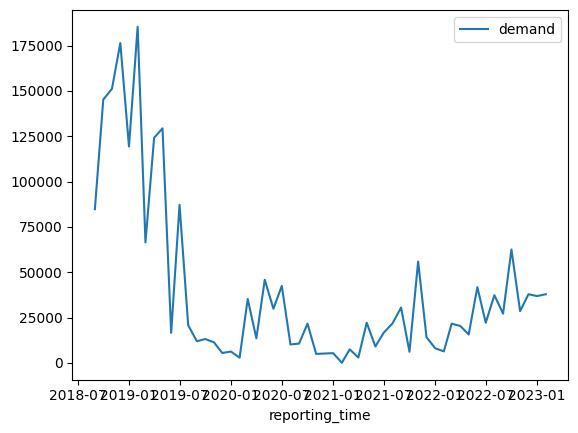

In [3]:
data_p1862 = data_new.loc[data['product_name']=='P1862']
data_p1862 = data_p1862[['reporting_time', 'demand']]
data_p1862.reset_index(inplace=True, drop=True)
data_p1862.plot(x = 'reporting_time', y = 'demand')
data_p1862 = data_p1862.set_index('reporting_time')

### LSTM

In [4]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(data_p1801)

In [5]:
X_train = []   #預測點的前 40 天的資料
y_train = []   #預測點
for i in range(40, 54):  # 54 是訓練集總數
    X_train.append(training_set_scaled[i-40:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

In [6]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
# Initialising the RNN
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [8]:
regressor.add(Dense(units = 1))

In [9]:
# Compiling
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 進行訓練
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1/1 [==============================] - 12s 12s/step - loss: 0.0338
Epoch 2/100
1/1 [==============================] - 0s 83ms/step - loss: 0.0232
Epoch 3/100
1/1 [==============================] - 0s 84ms/step - loss: 0.0143
Epoch 4/100
1/1 [==============================] - 0s 95ms/step - loss: 0.0074
Epoch 5/100
1/1 [==============================] - 0s 99ms/step - loss: 0.0106
Epoch 6/100
1/1 [==============================] - 0s 102ms/step - loss: 0.0121
Epoch 7/100
1/1 [==============================] - 0s 99ms/step - loss: 0.0091
Epoch 8/100
1/1 [==============================] - 0s 104ms/step - loss: 0.0082
Epoch 9/100
1/1 [==============================] - 0s 134ms/step - loss: 0.0083
Epoch 10/100
1/1 [==============================] - 0s 123ms/step - loss: 0.0074
Epoch 11/100
1/1 [==============================] - 0s 107ms/step - loss: 0.0093
Epoch 12/100
1/1 [==============================] - 0s 106ms/step - loss: 0.0082
Epoch 13/100
1/1 [=========================

In [10]:
dataset_total = pd.concat((data_p1801['demand'], data_p1862['demand']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(data_p1862) - 40:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling

X_test = []
for i in range(40, 94):  # timesteps一樣20； 94 = 先前的40天資料+54天資料
    X_test.append(inputs[i-40:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 
predicted_demand = regressor.predict(X_test)
predicted_demand = sc.inverse_transform(predicted_demand)


c:\Users\melov\OneDrive\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


2/2 [==============================] - 2s 24ms/step


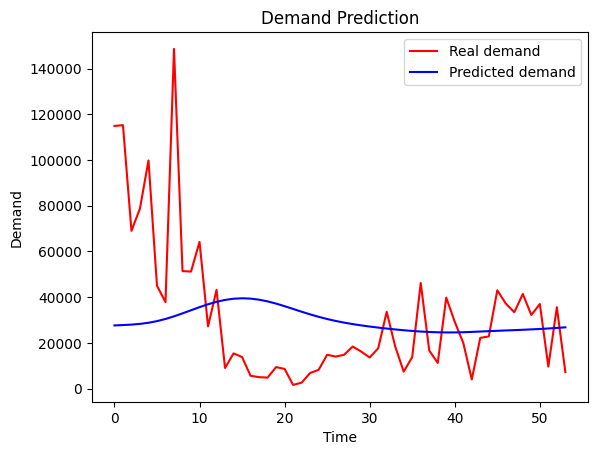

In [11]:
# Visualising the results
plt.plot(data_p1801['demand'].values, color = 'red', label = 'Real demand')  # 紅線表示真實股價
plt.plot(predicted_demand, color = 'blue', label = 'Predicted demand')  # 藍線表示預測股價
plt.title('Demand Prediction')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

### Facebook Propet

In [52]:
from prophet import Prophet
m = Prophet()
data_p1801['ds'] = data_p1801.index
data_p1801.rename(columns={'demand':'y'}, inplace=True)
m.fit(data_p1801)

00:53:40 - cmdstanpy - INFO - Chain [1] start processing
00:53:41 - cmdstanpy - INFO - Chain [1] done processing


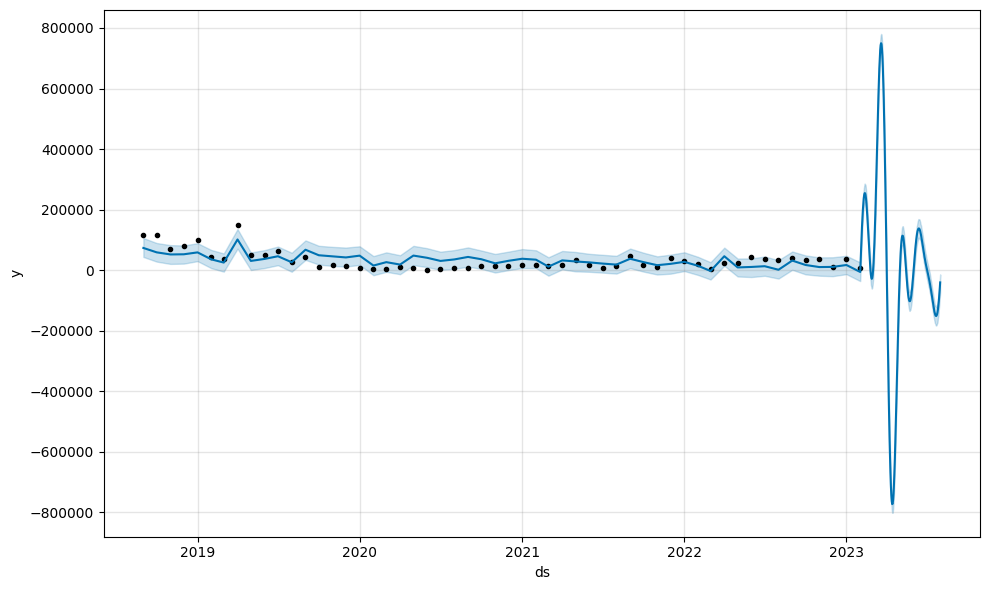

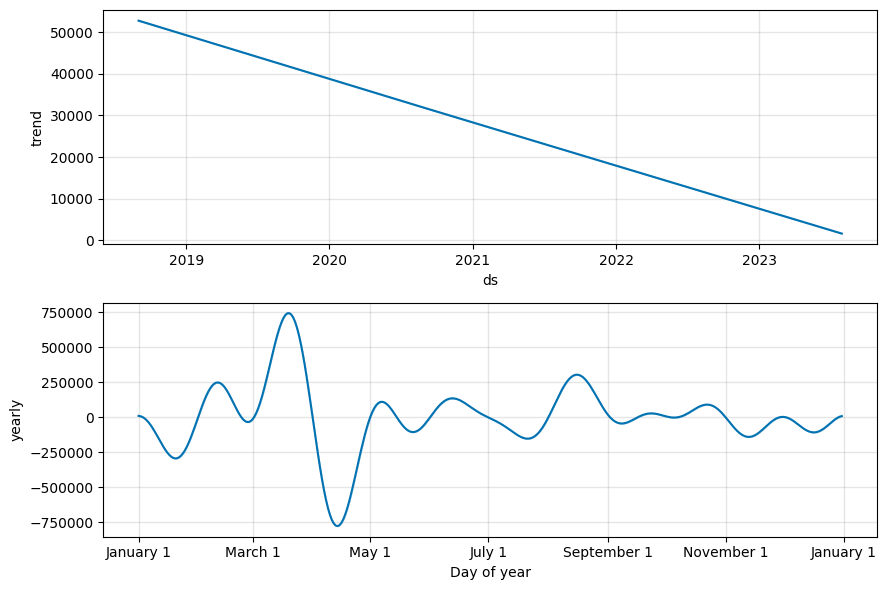

In [53]:
future = m.make_future_dataframe(periods=180)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

# Python
fig2 = m.plot_components(forecast)


### Random Forest

In [54]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
data = pd.read_csv('20230411_SummerTerm23_Data_Challenge_Infineon_Data.csv')
data_new = data
data_new['reporting_time'] = pd.to_datetime(data_new['reporting_time'])
data_new['reporting_time'] = data_new['reporting_time'].dt.date
data_gb = data.groupby('product_name')['reporting_time'].nunique()
data_p1801 = data_new.loc[data['product_name']=='P1801']
data_p1801 = data_p1801[['reporting_time', 'demand']]
data_p1801.reset_index(inplace=True, drop=True)
# data_p1801.plot(x = 'reporting_time', y = 'demand')
# data_p1801 = data_p1801.set_index('reporting_time')
# Prepare the data
data_p1801.rename(columns = {"reporting_time": "ds", "demand": "y"}, inplace = True)


In [55]:
data = data_p1801

In [56]:
# Create lagged features
num_lags = 12  # Number of lagged values to include
for i in range(1, num_lags + 1):
    data[f"lag_{i}"] = data["y"].shift(i)

In [57]:

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)  # 80% for training, 20% for testing
train_data = data[:train_size]
test_data = data[train_size:]

# Prepare the feature matrix and target variable for training
X_train = train_data.dropna().drop(["ds", "y"], axis=1)
y_train = train_data.dropna()["y"]

In [58]:
# Train the Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Prepare the feature matrix and target variable for testing
X_test = test_data.dropna().drop(["ds", "y"], axis=1)
y_test = test_data.dropna()["y"]

# Make predictions
predictions = rf_model.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")

# Generate future dates for prediction
future = pd.DataFrame(index=pd.date_range(start=data["ds"].max(), periods=12, freq="M"), columns=data.columns)

RMSE: 15375.917546736531


In [59]:
# Fill in lagged values for prediction
for i in range(1, num_lags + 1):
    future[f"lag_{i}"] = data["y"].shift(i).tail(num_lags).values

In [60]:
# Make predictions for the future dates
future["predicted_demand"] = rf_model.predict(future.drop(["ds", "y"], axis=1))
future=future.reset_index()


In [61]:
# Print the predicted demand
print(future[["index", "predicted_demand"]])

        index  predicted_demand
0  2023-02-28       9004.000000
1  2023-03-31      24890.000000
2  2023-04-30      24642.000000
3  2023-05-31      17816.666667
4  2023-06-30      13530.666667
5  2023-07-31      22559.333333
6  2023-08-31      22432.000000
7  2023-09-30      24886.000000
8  2023-10-31      25711.333333
9  2023-11-30      21316.666667
10 2023-12-31      22947.333333
11 2024-01-31      28174.666667


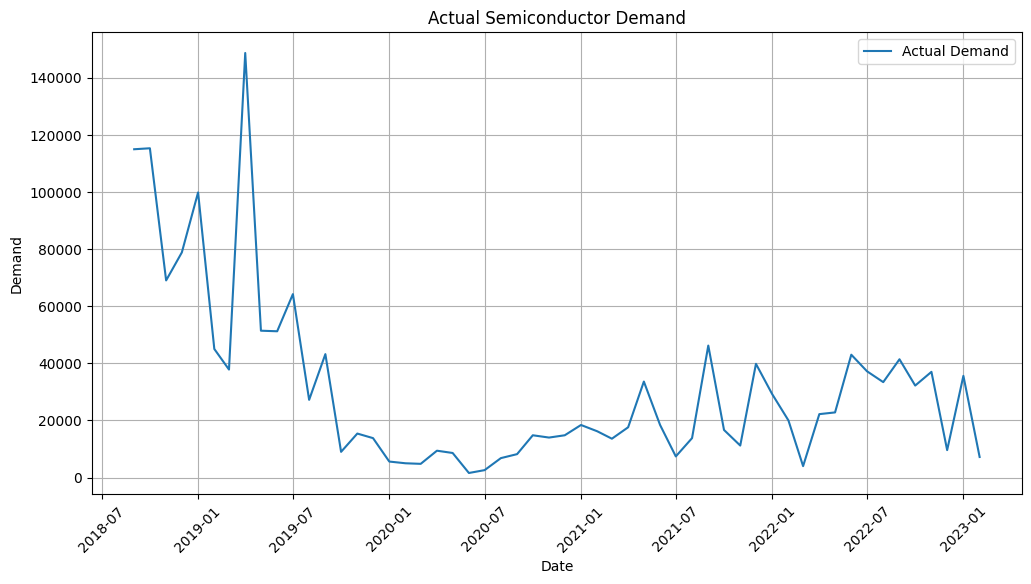

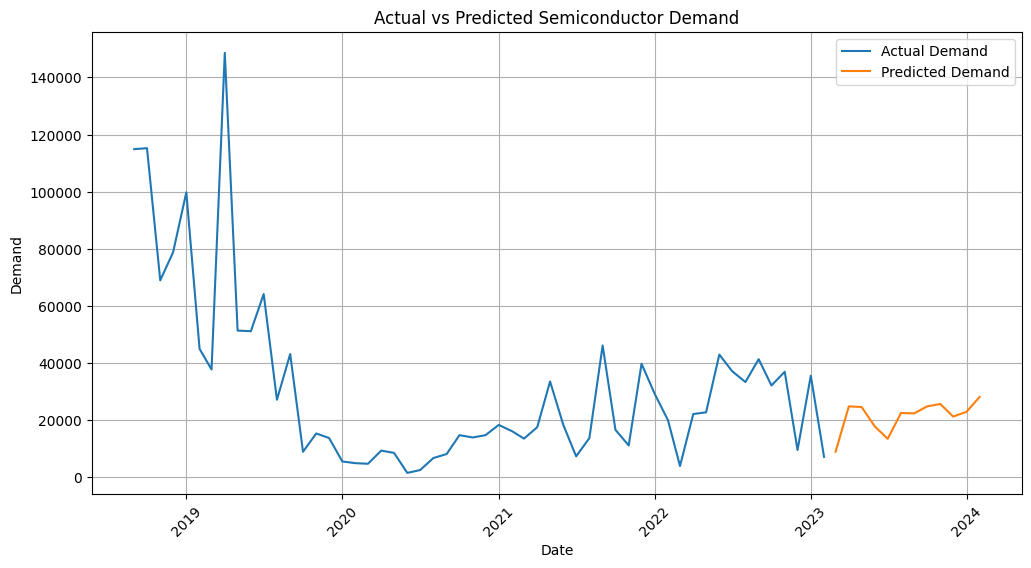

In [62]:
import matplotlib.pyplot as plt

# Plot actual demand
plt.figure(figsize=(12, 6))
plt.plot(data["ds"], data["y"], label="Actual Demand")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Actual Semiconductor Demand")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot predicted demand
plt.figure(figsize=(12, 6))
plt.plot(data["ds"], data["y"], label="Actual Demand")
plt.plot(future["index"], future["predicted_demand"], label="Predicted Demand")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Actual vs Predicted Semiconductor Demand")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
